# Phase 4 Project: Sentiment Analysis and Twitter

- Flatiron School, Data Science
- **Author**: Mohammad Abou-Ghazala
- **Instructor**: Mark Barbour

# Business Understanding

Our company, Microsoft, wants to be able to factor in sentiments about our products that are expressed on social media platforms, namely X (formerly Twitter), where millions of users share positive, negative, or neutral sentiments about products they use in an organic way. While consumer or user reviews left through official platforms such as Yelp or Amazon are important to consider, the pool of users is rather limited as not everyone will go the extra mile to provide a review through those "official" channels, and taking more organic feedback expressed through platforms like X into consideration can provide us an extra layer of insight as to how the public is interacting with and perceiving our products. 

Specifically, Microsoft wants to be able to filter tweets carrying Positive sentiments towards our products or services so that we are able to assess what's working well and what areas can and should be developed further.

The way we will go about this, is to create a **binary classifier model** that is trained and tested on a dataset containing tweets where users expressed various emotions or reactions to other products, as the essential issue is how well our model is able to parse through and differentiate between Positive tweets on the one hand, and Negative or Neutral tweets on the other hand.

In evaluating the efficacy of our model, we need to ascertain how effective the model was at correctly identifying Positive tweets. Put differently, we need to keep an eye out for **False Positives**, since our model would cause many issues for us if it incorrectly pulled in Negative or Neutral tweets, which would complicate or muddy our analysis. While False Negatives are also something to consider, they are of less importance as missing out on Positive tweets would be less damaging to us as it is generally better to avoid overestimating Positive feedback anyway.

# Data Understanding

As this problem is about analyzing and categorizing sentiments expressed through text, we will need to build a model capable of Natural Language Processing, or NLP for short. This model needs to be adept at processing and parsing through text, and categorizing the text as 'Positive', 'Not Positive' (ie: 'Negative' or 'Neutral').

We will engage in NLP to build a binary classifier that is capable of differentiating between 'Positive' and 'Negative' or 'Neutral' sentiments.

### Dataset
For these purposes, we will work with a [dataset we retrieved from data.world](https://data.world/crowdflower/brands-and-product-emotions) that contains more than 9,000 tweets expressing Positive, Negative, or Neutral sentiments towards Apple or Google products.

The dataset contains information across three columns:
1. `tweets_text`, which contains the text of the collected tweets themselves.
2. `emotion_in_tweet_is_directed_at`, which indicates which product the tweet is speaking to. This column contains a number of values, however they all fall under either Apple of Google products (with the exception of a number of rows that contain 'No data').
3. `is_there_an_emotion_directed_at_a_brand_or_product`, which categorizes the collected tweets according to either 'Positive emotion', 'Negative emotion', or 'No emotion toward brand or product'. There is a fourth category, 'I can't tell', which we need to investigate more before deciding whether or not to remove these entries.

### Features and Labels
The `tweets_text` column will serve as our features, or X, while `is_there_an_emotion_directed_at_a_brand_or_product` will serve as our labels, or y. 

To be more specific, we will use the `tweets_text` column to generate **TF-IDF (Term Frequency-Inverse Document Frequency)** scores, which assigns numeric values for key terms by weighing their frequency within a certain text against their frequency across different texts. This will help our model in gaining signals from significant words and reduce noise from frequent, insignificant words. These will be our features, at least in the initial baseline model.

The second column, `emotion_in_tweet_is_directed_at`, is not relevant for our purposes, as our task is to build a model that can categorize the sentiments expressed, and not to determine *whom* the sentiments are addressing.

### Class Imbalance
Our labels have significant class imbalance, with Negative sentiments only comprising 6% of the data compared to 33% for Positive and 59% for Neutral. Since we are adding the Negative and Neutral tweets together in a single class, this gives us:
- 33% Positive
- 65% Not Positive
  
This will cause issues for us in both training the model and evaluating its performance according to success metrics.

To compensate for this imbalance we will deploy **Class Weighting**, which is a strategy that can be used with certain models that gives higher importance to minority classes. 

### Success Metrics
As described above, we need to pay extra mind to our model's ability to correctly identify Positive tweets, placing a higher importance on the rates of False Positives. However, we should also keep an eye on False Negatives to minimize the number of Positive tweets falling through the cracks.

For this reason, we will rely on the following metrics:
1. **Precision Score**, which evaluates how accurate we were in actually identifying Positive tweets (telling us the rates of False Positives). The higher the precision score, the lower the rate of False Positives. This will be our primary metric.
2. **F1 Score**, which weighs the rate of False Positives and False Negatives, since we also want to minimize the rate at which we misclassify Positive tweets as Not Positive. This will be a seconadry metric for us.
3. **Recall Score**, which is essentially the inverse of Precision in that it measures the rate of False Negatives and True Negatives. It will tell us how many True Positives are falling through the cracks and can supplement Precision.

### Model Selection
We will start with a simple baseline model as an initial performance check before moving on to more complex models. Since we have some class imbalance, we will deploy **Multinomial Naive Bayes (Multinomial NB)**, which can help compensate for this imbalance using a weighted approach. This model is also better at producing the metrics we outlined above. 

Multinomial NB will require us to compute **TF-IDF (Term Frequency-Inverse Document Frequency)**, as described above. However, this will have limited applicability on future application of the model, as future tweets will undoubtedly contain new slang and terms that arise and will not be computed in this current model.

After establishing a baseline, we will then move on to testing out more complex models.

## Data Preparation

Since we want to first run a baseline MultinomialNB model, we will need to carry out several steps of Data Preparation in order for the data to be ready for modeling. 

In [1]:
# importing necessary libraries

import re
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter
from tqdm import tqdm
import lightgbm as lgb
from lightgbm import LGBMClassifier
from scipy.stats import loguniform, randint
import gensim.downloader as api
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)


In [2]:
# loading the data
# specifying the encoding as the file is a non-UTF-8 CSV file

df = pd.read_csv("data/judge_tweet_product.csv", encoding="latin-1")

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


As discussed earlier, the `emotion_in_tweet_is_directed_at` column is not necessary for our purposes of determining the sentiment of the tweet, so we will drop it from our DataFrame.

In [3]:
# dropping the second column

df = df.drop('emotion_in_tweet_is_directed_at', axis=1)


In [4]:
# checking if dropping column worked

df.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


#### Now we need to check for any null values.

In [5]:
df.isna().sum()

tweet_text                                            1
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

We have one row with null values. Let's take a look to see if we're able to simply drop it.

In [6]:
df[df.isna().any(axis=1)]

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,No emotion toward brand or product


In [7]:
# dropping the row with null value

df = df.dropna()

# making sure it worked

df.isna().sum()

tweet_text                                            0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

#### Cleaning Target Values

In [8]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

There is a fourth category in our Target column, **'I can't tell'**, indicating that those who gathered this dataset were unsure about the sentiment expressed in about 2% of the tweets. 

Let's take a quick look. Since they only make up 2% of the dataset, it may be best to simply drop these entries and focus on our analysis on the Positive, Negative, and Neutral categories.

In [9]:
df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"]

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
90,Thanks to @mention for publishing the news of ...,I can't tell
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,I can't tell
237,Just what America needs. RT @mention Google to...,I can't tell
341,The queue at the Apple Store in Austin is FOUR...,I can't tell
368,Hope it's better than wave RT @mention Buzz is...,I can't tell
...,...,...
9020,It's funny watching a room full of people hold...,I can't tell
9032,"@mention yeah, we have @mention , Google has n...",I can't tell
9037,"@mention Yes, the Google presentation was not ...",I can't tell
9058,&quot;Do you know what Apple is really good at...,I can't tell


In [10]:
# removing "I can't tell" entries in the Target column from the dataframe

df_clean = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

In [11]:
df_clean

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion
...,...,...
9088,Ipad everywhere. #SXSW {link},Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,No emotion toward brand or product


In [12]:
# checking to see if it worked

df_clean['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: count, dtype: int64

Since our Target column contains three categories ("Positive emotion, "Negative emotion", "No emotion toward brand or product"), and we'll need to collapse the latter two labels into a single category in order for us to conduct binary classification.

We'll do this by converting the label values into 1s and 0s.
- `1` meaning Positive
- `0` meaning Not Positive

In [13]:
# mapping 1s and 0s onto the Target column values

df_clean.loc[:,'is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map({
    'Positive emotion': 1,
    'Negative emotion': 0,
    'No emotion toward brand or product': 0
})

# converting binary values into integers

df_clean.loc[:,'is_there_an_emotion_directed_at_a_brand_or_product'] = \
df_clean['is_there_an_emotion_directed_at_a_brand_or_product'].astype(int)

In [14]:
# making sure it worked

df_clean['is_there_an_emotion_directed_at_a_brand_or_product'].unique()

array([0, 1], dtype=object)

For convenience, we'll change the name of our Target column to something shorter.

In [15]:
df_clean = df_clean.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'is_positive'})

# checking if it worked

df_clean.head()

,tweet_text,is_positive
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1


#### Train-Test-Splitting
Now that our dataset is cleaned, we'll split the data into training and test sets before preprocessing the text data in order to prevent data leakage.

In [16]:
# setting X (Features) and y (Target)

X = df_clean[['tweet_text']]
y = df_clean['is_positive'].astype(int)

# splitting the data

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)

In [17]:
# splitting training sets into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2, random_state=42
)

In [18]:
y.unique

<bound method Series.unique of 0       0
1       1
2       1
3       0
4       1
       ..
9088    1
9089    0
9090    0
9091    0
9092    0
Name: is_positive, Length: 8936, dtype: int64>

#### Creating Custom Transformers

We can now start preparing our X variable (features) for our modeling.

We'll need to convert all words to lowercase, remove special characters, remove stop words, tokenize the text and apply lemmatization in order for our text to be processed uniformly across all variations of the same words.

These steps can be built into our Pipeline, which we will deploy to prevent data leakage.

First, we need to create a **custom transformer** to carry out these steps, before creating the Pipeline.

In [19]:
# defining custom transformer with parameters that allow it to work like an sklearn transformer inside the pipelines

class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    Custom transformer that:
    1) Lowercases text,
    2) Removes special characters,
    3) Tokenizes text,
    4) Removes stopwords,
    5) Lemmatizes text.
    """

    def __init__(self):
        pass  # No need for custom_stopwords anymore

    def fit(self, X, y=None):
        """Initialize lemmatizer and stopwords"""
        self._lemmatizer = WordNetLemmatizer()
        self._stop_words = set(stopwords.words('english'))
        self.n_features_in_ = 1  # Required for scikit-learn compatibility
        return self

    def transform(self, X):
        """Preprocess text data"""
        if not hasattr(self, "_lemmatizer") or not hasattr(self, "_stop_words"):
            raise ValueError("TextPreprocessor has not been fitted yet.")
        
        preprocessed_texts = []
        for text in X:
            if not isinstance(text, str):  # Ensure input is a string
                text = str(text)
            text = text.lower()
            text = re.sub(r'[^a-z\s]', '', text)
            tokens = nltk.word_tokenize(text)
            filtered_tokens = [word for word in tokens if word not in self._stop_words]
            lemmatized_text = ' '.join([self._lemmatizer.lemmatize(word) for word in filtered_tokens])
            preprocessed_texts.append(lemmatized_text)
        return preprocessed_texts



#### Custom Stop Words
While our custom function above removes standard stop words downloaded from nltk, social media and Twitter in particular most likely make use of words that would be considered frivolous within the context of social media but are not on the downloaded stop words list.

From here, we can pull words we think don't add much value to the content considering the context of Twitter.

In [20]:
# Initializing processor
processor = TextPreprocessor()

processed_tweets = processor.fit_transform(X['tweet_text'])

# tokenizing the tweets
all_tokens = " ".join(processed_tweets).split()

word_counts = Counter(all_tokens)

# looking at 200 most common words
print(word_counts.most_common(200))

[('sxsw', 9377), ('mention', 6950), ('link', 4247), ('rt', 2897), ('ipad', 2828), ('google', 2474), ('apple', 2217), ('iphone', 1486), ('store', 1482), ('new', 1080), ('austin', 946), ('app', 803), ('amp', 722), ('launch', 682), ('social', 629), ('circle', 624), ('popup', 590), ('today', 565), ('android', 562), ('network', 464), ('get', 450), ('line', 433), ('via', 424), ('free', 383), ('party', 375), ('called', 354), ('sxswi', 336), ('mobile', 334), ('one', 306), ('major', 301), ('time', 297), ('like', 288), ('day', 277), ('map', 263), ('temporary', 262), ('u', 256), ('opening', 255), ('im', 254), ('open', 249), ('win', 242), ('possibly', 240), ('need', 234), ('come', 226), ('go', 225), ('see', 224), ('apps', 223), ('downtown', 222), ('people', 221), ('great', 219), ('mayer', 217), ('check', 215), ('going', 213), ('w', 209), ('dont', 198), ('know', 192), ('marissa', 191), ('got', 180), ('want', 176), ('make', 176), ('first', 166), ('year', 164), ('good', 163), ('say', 161), ('set', 16

In [21]:
# creating custom words set from words above

custom_words = set([
    'rt', 'just', 'will', 'get', 'one', 'know', 'think', 'dont', 'time', 
    'u', 'now', 'go', 'back', 'make', 'say', 'feel', 'apple', 'google', 'ipad',
    'sxsw', 'store', 'new', 'austin', 'amp', 'launch', 'iphone', 'android',
    'social', 'circle', 'line', 'via', 'free', 'party', 'called', 'the', 'ive', 'a',
    'sxswi', 'mobile', 'major', 'location', 'download', 'tweet', 'japan', 'dont', 'know', 
    'shop', 'talk', 'design', 'best', 'thanks', 'show', 'tweet', 'itunes',
    'use', 'around', 'last', 'session', 'would', 'thing', 'right' 
])


Now we will combine our custom set with the standard NLTK stop words to create our own `custom_stop_words` set.

In [22]:
# loading standard NLTK stop words

nltk_stop_words = set(stopwords.words('english'))

# combining standard stop words with our custom word set

custom_stop_words = custom_words.union(nltk_stop_words)

custom_stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'amp',
 'an',
 'and',
 'android',
 'any',
 'apple',
 'are',
 'aren',
 "aren't",
 'around',
 'as',
 'at',
 'austin',
 'back',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'best',
 'between',
 'both',
 'but',
 'by',
 'called',
 'can',
 'circle',
 'couldn',
 "couldn't",
 'd',
 'design',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'dont',
 'down',
 'download',
 'during',
 'each',
 'feel',
 'few',
 'for',
 'free',
 'from',
 'further',
 'get',
 'go',
 'google',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'ipad',
 'iphone',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'itunes',
 'ive',
 'ja

#### Creating Pipelines

##### **Baseline Model**

Now we can prepare Pipelines for our models. We will start with our Baseline model, MultinomialNB. 

This Pipeline will cover the following steps:
1. Run the Custom Transformer we just created.
2. Vectorize the text into TF-IDF features.
3. Run a MultinomialNB model.

In [23]:
# creating Pipeline for MultinomialNB modeling

baseline_pipe = Pipeline([
    ('preprocessor', TextPreprocessor()), # preprocessing transformer, 
                                                                      # removing custom + standard stop words
    ('vectorizer', TfidfVectorizer()), # Convert to TF-IDF features
    ('classifier', MultinomialNB(class_prior=[0.67, 0.33])), # Run the MultinomialNB model, adjusted for minority class
])

##### **Logistic Regression Model**

We'll do the same for a LogisticRegression classifier.

In [24]:
logreg_pipe = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(
        max_iter=1000, # increasing iterations to capture data complexity
        class_weight='balanced',# balancing in favor of minority class
        random_state=42 
    ))
])

# Modeling

With our two pipelines prepared, we can proceed with modeling.

First we will need to train the models on our training data and evaluate their performance using the metrics we outlined above (Precision and F1). 

In [25]:
model_results = []

def store_results(model_name, precision, recall, f1):
    """
    Store metrics for all our models
    """
    model_results.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

In [26]:
# fitting and running baseline model (MultinomialNB)
baseline_pipe.fit(X_train['tweet_text'], y_train)

# predicting validation set
y_val_pred_baseline = baseline_pipe.predict(X_val['tweet_text'])

# evaluating baseline model
baseline_precision = precision_score(y_val, y_val_pred_baseline)
baseline_recall = recall_score(y_val, y_val_pred_baseline)
baseline_f1 = f1_score(y_val, y_val_pred_baseline)

print(f'Baseline Precision: {baseline_precision}')
print(f'Baseline Recall: {baseline_recall}')
print(f'Baseline F1: {baseline_f1}')


Baseline Precision: 0.8021978021978022
Baseline Recall: 0.15938864628820962
Baseline F1: 0.2659380692167577


In [27]:
# saving the baseline model
store_results('BaselineMNB', baseline_precision, baseline_recall, baseline_f1)

While we have a decent Precision score of 80%, we have very poor Recall and F1 scores, indicating that while the model is good at identifying a positive class, it is allowing many actual positive cases to fall through the cracks.

Let's try our LogReg model and compare.

In [28]:
logreg_pipe.fit(X_train['tweet_text'], y_train)

y_val_pred_logreg = logreg_pipe.predict(X_val['tweet_text'])

logreg_precision = precision_score(y_val, y_val_pred_logreg)
logreg_recall = recall_score(y_val, y_val_pred_logreg)
logreg_f1 = f1_score(y_val, y_val_pred_logreg)

print(f'LogReg Precision: {logreg_precision}')
print(f'LogReg Recall: {logreg_recall}')
print(f'LogReg F1: {logreg_f1}')

LogReg Precision: 0.566990291262136
LogReg Recall: 0.6375545851528385
LogReg F1: 0.6002055498458376


While our LogReg model did significantly worse in terms of Precision, it did much better in terms of Recall and F1 scores, indicating less positive cases are falling through the cracks here, however it is mispredicting a good number of Positive cases that are not actually Positive.

In [29]:
# saving our vanilla LogReg model

store_results('LogReg Vanilla', logreg_precision, logreg_recall, logreg_f1)

In [30]:
model_results

[{'Model': 'BaselineMNB',
  'Precision': 0.8021978021978022,
  'Recall': 0.15938864628820962,
  'F1': 0.2659380692167577},
 {'Model': 'LogReg Vanilla',
  'Precision': 0.566990291262136,
  'Recall': 0.6375545851528385,
  'F1': 0.6002055498458376}]

## Tuning Hyperparameters

It seems neither of our current models have done a great job according to the metrics, with a lot of imbalance in terms of the scores.

Let's try to hypertune the parameters for these models. We will use `RandomSearchCV` for this as it is less costly and time-consuming than `GridSearchCV`.

In [31]:
# creating the parameter grid

param_grid_logreg = {
    'vectorizer__max_df': np.linspace(.7, 1, 4),
    'vectorizer__min_df': [1, 5, 10],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'classifier__C': np.logspace(-2, 1, 5),
    'classifier__penalty': ['l2'], 
    'classifier__solver': ['liblinear', 'lbfgs']
}

In [32]:
# conducting the Randomized Search to find best parameters

rand_search_logreg = RandomizedSearchCV(
    logreg_pipe, param_grid_logreg,
    n_iter=15,
    cv=5,
    scoring='f1',
    n_jobs=1,
    verbose=2,
    random_state=42
)

rand_search_logreg.fit(X_train['tweet_text'], y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1); total time=   0.5s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1); total time=   0.5s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1); total time=   0.5s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1); total time=   0.5s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1); total time=   0.5s
[CV] END classifier__C=0.01, classifier__penalty=l2, classi

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              TextPreprocessor()),
                                             ('vectorizer', TfidfVectorizer()),
                                             ('classifier',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=1000,
                                                                 random_state=42))]),
                   n_iter=15, n_jobs=1,
                   param_distributions={'classifier__C': array([ 0.01      ,  0.05623413,  0.31622777,  1.77827941, 10.        ]),
                                        'classifier__penalty': ['l2'],
                                        'classifier__solver': ['liblinear',
                                                               'lbfgs'],
                                        'vectorizer__max_df': array([0.7, 0.8, 0.9, 1. ]),
                                        'vectorizer__min_df': [1, 5, 10],
                                        'vectorizer__ngram_range': [(1, 1),
                                                                    (1, 2)]},
                   random_state=42, scoring='f1', verbose=2)

In [33]:
print("Best Parameters:", rand_search_logreg.best_params_)
print("Best Score:", rand_search_logreg.best_score_)

Best Parameters: {'vectorizer__ngram_range': (1, 1), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.7, 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 1.7782794100389228}
Best Score: 0.580695244265444


It seems that a hypertuned LogReg model brought a worse F1 score than the vanilla LogReg, at least on training data.

let's see how it performs on the validation data.

In [34]:
y_val_pred_logreg_tuned = rand_search_logreg.best_estimator_.predict(X_val['tweet_text'])

logreg_tuned_precision = precision_score(y_val, y_val_pred_logreg_tuned)
logreg_tuned_recall = recall_score(y_val, y_val_pred_logreg_tuned)
logreg_tuned_f1 = f1_score(y_val, y_val_pred_logreg_tuned)

print(f'LogReg Tuned Precision: {logreg_tuned_precision}')
print(f'LogReg Tuned Recall: {logreg_tuned_recall}')
print(f'LogReg Tuned F1: {logreg_tuned_f1}')

LogReg Tuned Precision: 0.5697445972495089
LogReg Tuned Recall: 0.6331877729257642
LogReg Tuned F1: 0.5997931747673216


Even with our best parameters tuned, this LogReg model has similar Precision and Recall to the vanilla LogReg, and slightly worse F1, indicating that it can generalize on unseen data about just as well as it can on training data.

Let's try another model, then.

In [35]:
store_results('LogReg Tuned', logreg_tuned_precision, logreg_tuned_recall, logreg_tuned_f1)

### LightGBM

The Light Gradient Boosting Maching (LightGBM) is a gradient boosting model that is capable of handling large datasets efficiently. As an ensemble model that builds decision trees sequentially, each layer of trees corrects errors from previous layers, and it checks features in groups rather than individually, which can serve us here.

In [36]:
# creating the LGBM pipeline

lgbm_pipe = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LGBMClassifier(n_estimators=100,
                                 learning_rate=0.1,
                                 class_weight='balanced'))
])

In [37]:
lgbm_pipe.fit(X_train['tweet_text'], y_train)

y_val_pred_lgbm = lgbm_pipe.predict(X_val['tweet_text'].values)

lgbm_precision = precision_score(y_val, y_val_pred_lgbm)
lgbm_recall = recall_score(y_val, y_val_pred_lgbm)
lgbm_f1 = f1_score(y_val, y_val_pred_lgbm)

print(f'LGBM Precision: {lgbm_precision}')
print(f'LGBM Recall: {lgbm_recall}')
print(f'LGBM F1: {lgbm_f1}')

[LightGBM] [Info] Number of positive: 1801, number of negative: 3560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10822
[LightGBM] [Info] Number of data points in the train set: 5361, number of used features: 411
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LGBM Precision: 0.5553470919324578
LGBM Recall: 0.6462882096069869
LGBM F1: 0.5973763874873865


In [38]:
store_results('LGBM Vanilla', lgbm_precision, lgbm_recall, lgbm_f1)

This vanilla LGBM model seems to perform on par with our LogReg model, indicating not much progress so far. 

Let's see if **hyptertuning parameters** can assist this model's performance.

In [39]:
# setting up the parameter grid for LGBM

param_grid_lgbm = {
    'classifier__num_leaves': randint(10, 200),  # sample between 10 and 200 leaves
    'classifier__learning_rate': loguniform(0.005, 0.2),  # gog-scale sampling between 0.005-0.2
    'classifier__max_depth': randint(3, 15),  # integer sampling between 3-15
    'classifier__n_estimators': randint(100, 1000),  # sample between 100-1000 estimators
    'classifier__subsample': loguniform(0.5, 1.0),  # sample between 50-100%
    'classifier__colsample_bytree': loguniform(0.5, 1.0),  # same for column sampling
    'classifier__reg_alpha': loguniform(1e-3, 10),  # regularization alpha (L1)
    'classifier__reg_lambda': loguniform(1e-3, 10),  # regularization lambda (L2)
}

In [40]:
# running the Randomized Search

rand_search_lgbm = RandomizedSearchCV(
    lgbm_pipe, param_grid_lgbm,
    n_iter=20,
    cv=3,
    scoring='f1',
    n_jobs=1,
    verbose=2,
    random_state=42
)

rand_search_lgbm.fit(X_train['tweet_text'], y_train)



Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 1201, number of negative: 2373
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7135
[LightGBM] [Info] Number of data points in the train set: 3574, number of used features: 278
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              TextPreprocessor()),
                                             ('vectorizer', TfidfVectorizer()),
                                             ('classifier',
                                              LGBMClassifier(class_weight='balanced'))]),
                   n_iter=20, n_jobs=1,
                   param_distributions={'classifier__colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15f193ac0>,
                                        'classifier__learning_rate'...
                                        'classifier__num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x163b38700>,
                                        'classifier__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x162c115e0>,
                                        'classifier__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x162055130>,
                                        'classifier__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x163b389a0>},
                   random_state=42, scoring='f1', verbose=2)

In [41]:
print("Best Parameters:", rand_search_lgbm.best_params_)
print("Best Score:", rand_search_lgbm.best_score_)

Best Parameters: {'classifier__colsample_bytree': 0.7170114293588699, 'classifier__learning_rate': 0.03756926249576086, 'classifier__max_depth': 8, 'classifier__n_estimators': 576, 'classifier__num_leaves': 155, 'classifier__reg_alpha': 1.2604664585649468, 'classifier__reg_lambda': 5.727904470799623, 'classifier__subsample': 0.9296936780589198}
Best Score: 0.5355527737974688


Despite the long time that took to run, somehow even a tuned LGBM model is doing worse than our LogReg model, with a 54% F1 score, which is lower than the vanilla LGBM model.

Let's see how it performs on our validation data.

In [42]:
y_val_pred_lgbm_tuned = rand_search_lgbm.best_estimator_.predict(X_val['tweet_text'])

lgbm_tuned_precision = precision_score(y_val, y_val_pred_lgbm_tuned)
lgbm_tuned_recall = recall_score(y_val, y_val_pred_lgbm_tuned)
lgbm_tuned_f1 = f1_score(y_val, y_val_pred_lgbm_tuned)

print(f'LGBM Tuned Precision: {lgbm_tuned_precision}')
print(f'LGBM Tuned Recall: {lgbm_tuned_recall}')
print(f'LGBM Tuned F1: {lgbm_tuned_f1}')

LGBM Tuned Precision: 0.544280442804428
LGBM Tuned Recall: 0.6441048034934498
LGBM Tuned F1: 0.59


Like with our LogReg model, this tuned LGBM model performs on par, if not slightly better, on unseen data, indicating low overfitting or underfitting. 

In [43]:
store_results('LGBM Tuned', lgbm_tuned_precision, lgbm_tuned_recall, lgbm_tuned_f1)

In [44]:
model_results

[{'Model': 'BaselineMNB',
  'Precision': 0.8021978021978022,
  'Recall': 0.15938864628820962,
  'F1': 0.2659380692167577},
 {'Model': 'LogReg Vanilla',
  'Precision': 0.566990291262136,
  'Recall': 0.6375545851528385,
  'F1': 0.6002055498458376},
 {'Model': 'LogReg Tuned',
  'Precision': 0.5697445972495089,
  'Recall': 0.6331877729257642,
  'F1': 0.5997931747673216},
 {'Model': 'LGBM Vanilla',
  'Precision': 0.5553470919324578,
  'Recall': 0.6462882096069869,
  'F1': 0.5973763874873865},
 {'Model': 'LGBM Tuned',
  'Precision': 0.544280442804428,
  'Recall': 0.6441048034934498,
  'F1': 0.59}]

While our baseline MultinomialNB model has by far the highest Precision score, the F1 and Recall scores are too abysmal.

Our LogReg models are performing almost identically to both LGBM models, but take a lot less computational time and resources to run.

Let's try to enhance our LogReg model by Feature Engineering.

#### Feature Engineering
**TF-IDF Bigrams**

Bigrams are pairs of words that enhance each other's significance when together. We can only get so far when we consider words in isolation, so perhaps considering the relationship between words can assist us in bettering our metrics.

In [45]:
# pulling the best model created by our previous RandomizedSearch on LogReg
best_logreg = rand_search_logreg.best_estimator_.named_steps['classifier']

# creating new pipeline to take account for bigrams
logreg_pipe_bigrams = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2),
                                  sublinear_tf=True)), # using unigrams as well as bigrams
    ('classifier', best_logreg) # best tuned LogReg model
])

logreg_pipe_bigrams.fit(X_train['tweet_text'], y_train)

y_val_pred_lr_bg = logreg_pipe_bigrams.predict(X_val['tweet_text'])

logreg_precision_bigrams = precision_score(y_val, y_val_pred_lr_bg)
logreg_recall_bigrams = recall_score(y_val, y_val_pred_lr_bg)
logreg_f1_bigrams = f1_score(y_val, y_val_pred_lr_bg)

print(f'LogReg FE-Bigrams Precision: {logreg_precision_bigrams}')
print(f'LogReg FE-Bigrams Recall: {logreg_recall_bigrams}')
print(f'LogReg FE-Bigrams F1: {logreg_f1_bigrams}')

LogReg FE-Bigrams Precision: 0.5816733067729084
LogReg FE-Bigrams Recall: 0.6375545851528385
LogReg FE-Bigrams F1: 0.6083333333333333


Slight improvement - but not enough.

Perhaps **trigrams** are worth investigating, which are the same as Bigrams just with three words instead of a pair.

In [46]:
# new pipeline for trigrams
logreg_pipe_trigrams = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,3),
                                  sublinear_tf=True)), # using unigrams as well as bigrams and trigrams
    ('classifier', best_logreg) # best tuned LogReg model
])

logreg_pipe_trigrams.fit(X_train['tweet_text'], y_train)

y_val_pred_lr_tg = logreg_pipe_trigrams.predict(X_val['tweet_text'])

logreg_precision_trigrams = precision_score(y_val, y_val_pred_lr_tg)
logreg_recall_trigrams = recall_score(y_val, y_val_pred_lr_tg)
logreg_f1_trigrams = f1_score(y_val, y_val_pred_lr_tg)

print(f'LogReg FE-Trigrams Precision: {logreg_precision_trigrams}')
print(f'LogReg FE-Trigrams Recall: {logreg_recall_trigrams}')
print(f'LogReg FE-Trigrams F1: {logreg_f1_trigrams}')

LogReg FE-Trigrams Precision: 0.5658914728682171
LogReg FE-Trigrams Recall: 0.6375545851528385
LogReg FE-Trigrams F1: 0.5995893223819302


This did slightly worse, so we should stick with bigrams.


**Word Embeddings**

Word embeddings are a strategy that represents words as numerical vectors, instead of one-off words, capturing the meaning and relationships between words in consideration of their context within wider text. In this way, they are more capable of capturing semantic meanings and nuances, and can help models understand and deal with synonyms or words with similar meanings.

We will use `FastText`, which is a useful tool for word embedding, in particular rare words and words in different forms.

In [47]:
# loading fasttext
fasttext_model = api.load("fasttext-wiki-news-subwords-300")

# creating a function that uses fasttext to turn out text data into word vectors
def fasttext_tweet(tweet):
    words = tweet.split()
    word_vectors = [fasttext_model[word] for word in words if word in fasttext_model.key_to_index]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(fasttext_model.vector_size)

# turning the vectors into arrays suitable for modeling
X_train_fast = np.array([fasttext_tweet(tweet) for tweet in X_train['tweet_text']])
X_val_fast = np.array([fasttext_tweet(tweet) for tweet in X_val['tweet_text']])
X_test_fast = np.array([fasttext_tweet(tweet) for tweet in X_test['tweet_text']])

In [48]:
# creating new pipeline specifically for running our fasttext data
logreg_pipe_fast = Pipeline([
    ('classifier', LogisticRegression()) 
])

logreg_pipe_fast.fit(X_train_fast, y_train)

y_val_pred_lr_fe_fast = logreg_pipe_fast.predict(X_val_fast)

lr_precision_fe_fast = precision_score(y_val, y_val_pred_lr_fe_fast)
lr_recall_fe_fast = recall_score(y_val, y_val_pred_lr_fe_fast)
lr_f1_fe_fast = f1_score(y_val, y_val_pred_lr_fe_fast)

print(f'LogReg FE Precision: {lr_precision_fe_fast}')
print(f'LogReg FE Recall: {lr_recall_fe_fast}')
print(f'LogReg FE F1: {lr_f1_fe_fast}')

LogReg FE Precision: 0.625
LogReg FE Recall: 0.12008733624454149
LogReg FE F1: 0.20146520146520147


This model did better than boht the vanilla and tuned LogReg models in terms of Precision, however it tanked in terms of Recall and F1.

In [49]:
store_results('LogReg Fasttext', lr_precision_fe_fast, lr_recall_fe_fast, lr_f1_fe_fast)
store_results('LogReg Trigrams', logreg_precision_trigrams, logreg_recall_trigrams, logreg_f1_trigrams)
store_results('LogReg Bigrams', logreg_precision_bigrams, logreg_recall_bigrams, logreg_f1_bigrams)
model_results

[{'Model': 'BaselineMNB',
  'Precision': 0.8021978021978022,
  'Recall': 0.15938864628820962,
  'F1': 0.2659380692167577},
 {'Model': 'LogReg Vanilla',
  'Precision': 0.566990291262136,
  'Recall': 0.6375545851528385,
  'F1': 0.6002055498458376},
 {'Model': 'LogReg Tuned',
  'Precision': 0.5697445972495089,
  'Recall': 0.6331877729257642,
  'F1': 0.5997931747673216},
 {'Model': 'LGBM Vanilla',
  'Precision': 0.5553470919324578,
  'Recall': 0.6462882096069869,
  'F1': 0.5973763874873865},
 {'Model': 'LGBM Tuned',
  'Precision': 0.544280442804428,
  'Recall': 0.6441048034934498,
  'F1': 0.59},
 {'Model': 'LogReg Fasttext',
  'Precision': 0.625,
  'Recall': 0.12008733624454149,
  'F1': 0.20146520146520147},
 {'Model': 'LogReg Trigrams',
  'Precision': 0.5658914728682171,
  'Recall': 0.6375545851528385,
  'F1': 0.5995893223819302},
 {'Model': 'LogReg Bigrams',
  'Precision': 0.5816733067729084,
  'Recall': 0.6375545851528385,
  'F1': 0.6083333333333333}]

Since most of our models, tuned or otherwise, were average at best, and our baseline MultinomialNB model had by far the best Precision despite abysmal F1 and Recall, let's try developing the baseline model further.

In [50]:
# hypertuning MultinomialNB model

mnb_pipe = Pipeline([
    ('preprocessor', TextPreprocessor()),      
    ('vectorizer', TfidfVectorizer()),           
    ('classifier', MultinomialNB()) 
])

class_priors = [
    [.33, .67],
    [.4, .6],
    [.5, .5],
    [.6, .4]
]

param_grid_mnb = {
    'classifier__alpha': np.logspace(-3, 1, 5), # tuning alphas for smoothing
    'classifier__fit_prior': [True, False],     # fitting class priors or using manual ones
    'classifier__class_prior': class_priors     # different sets of class priors for class imbalance
}

grid_search_mnb = GridSearchCV(
    estimator=mnb_pipe,
    param_grid=param_grid_mnb,
    cv=3,
    scoring='precision'
)

In [51]:
grid_search_mnb.fit(X_train['tweet_text'], y_train)

print("Best Parameters: ", grid_search_mnb.best_params_)

Best Parameters:  {'classifier__alpha': 10.0, 'classifier__class_prior': [0.5, 0.5], 'classifier__fit_prior': True}


In [52]:
y_val_pred_mnb_tuned = grid_search_mnb.best_estimator_.predict(X_val['tweet_text'])

mnb_tuned_precision = precision_score(y_val, y_val_pred_mnb_tuned)
mnb_tuned_recall = recall_score(y_val, y_val_pred_mnb_tuned)
mnb_tuned_f1 = f1_score(y_val, y_val_pred_mnb_tuned)

print(f'MNB Tuned Precision: {mnb_tuned_precision}')
print(f'MNB Tuned Recall: {mnb_tuned_recall}')
print(f'MNB Tuned F1: {mnb_tuned_f1}')

MNB Tuned Precision: 0.7884615384615384
MNB Tuned Recall: 0.08951965065502183
MNB Tuned F1: 0.1607843137254902


It seems our hypertuned MultinomialNB model performed even worse than the baseline MNB. We may be hitting the limits of what bwe're able to do with such an imbalanced dataset, with too few entries in the Positive case, particularly on average hardware.

Let's bring in one more model.

### Random Forest Classifier

Similar to LightGBM, Random Forest Classifier (RFC) is an ensemble learning method that combines multiple decision trees in its predictions. 

Whereas LightGBM builds trees sequentially (boosting), with each new tree correcting errors from previous trees, RFC trains multiple trees independently on random subsets of data (bagging) and conducts a majority vote for finding predictions. This can help any impact, however minimal, that slight overfitting has on our models' performances.

In [53]:
# creating new pipeline for RFC

rfc_pipe = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,3), max_features=10000)),
    ('classifier', RandomForestClassifier(class_weight='balanced')) # minimizing impact of class imbalance
])

rfc_pipe.fit(X_train['tweet_text'], y_train)

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 3))),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced'))])

In [54]:
y_val_pred_rfc = rfc_pipe.predict(X_val['tweet_text'])

rfc_precision = precision_score(y_val, y_val_pred_rfc)
rfc_recall = recall_score(y_val, y_val_pred_rfc)
rfc_f1 = f1_score(y_val, y_val_pred_rfc)

print(f'RFC Precision: {rfc_precision}')
print(f'RFC Recall: {rfc_recall}')
print(f'RFC F1: {rfc_f1}')

RFC Precision: 0.6567164179104478
RFC Recall: 0.38427947598253276
RFC F1: 0.48484848484848486


Our vanilla RFC model did a decent job with Precision, but with lower Recall and F1 scores, this model is continuing the same errors of the other models in letting too many Positive cases fall through the cracks.

Let's see if hypertuning helps.

In [55]:
# creating parameter grid for hypertuning
param_grid_rfc = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, None],  
    'classifier__min_samples_split': [2, 5, 10],  
}

grid_search_rfc = GridSearchCV(
    rfc_pipe, param_grid_rfc,
    cv=3, n_jobs=1,
    scoring='f1'
)

grid_search_rfc.fit(X_train['tweet_text'], y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor', TextPreprocessor()),
                                       ('vectorizer',
                                        TfidfVectorizer(max_features=10000,
                                                        ngram_range=(1, 3))),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced'))]),
             n_jobs=1,
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='f1')

In [56]:
grid_search_rfc.best_params_

{'classifier__max_depth': 10,
 'classifier__min_samples_split': 10,
 'classifier__n_estimators': 200}

Let's check how this tuned RFC model performs on unseen validation data.

In [57]:
y_val_pred_rfc_tuned = grid_search_rfc.best_estimator_.predict(X_val['tweet_text'])

rfc_tuned_precision = precision_score(y_val, y_val_pred_rfc_tuned)
rfc_tuned_recall = recall_score(y_val, y_val_pred_rfc_tuned)
rfc_tuned_f1 = f1_score(y_val, y_val_pred_rfc_tuned)

print(f'RFC Tuned Precision: {rfc_tuned_precision}')
print(f'RFC Tuned Recall {rfc_tuned_recall}')
print(f'RFC Tuned F1: {rfc_tuned_f1}')

RFC Tuned Precision: 0.5068027210884354
RFC Tuned Recall 0.6506550218340611
RFC Tuned F1: 0.5697896749521989


While the Precision score for the tuned RFC model is lower than the vanilla model, which may indicate some overfitting, the Recall and F1 scores are much better. Overall, these results are far more balanced than previous model results.

In [58]:
store_results('MultinomialNB Tuned', mnb_tuned_precision, mnb_tuned_recall, mnb_tuned_f1)
store_results('RFC Vanilla', rfc_precision, rfc_recall, rfc_f1)
store_results('RFC Tuned', rfc_tuned_precision, rfc_tuned_recall, rfc_tuned_f1)
model_results

[{'Model': 'BaselineMNB',
  'Precision': 0.8021978021978022,
  'Recall': 0.15938864628820962,
  'F1': 0.2659380692167577},
 {'Model': 'LogReg Vanilla',
  'Precision': 0.566990291262136,
  'Recall': 0.6375545851528385,
  'F1': 0.6002055498458376},
 {'Model': 'LogReg Tuned',
  'Precision': 0.5697445972495089,
  'Recall': 0.6331877729257642,
  'F1': 0.5997931747673216},
 {'Model': 'LGBM Vanilla',
  'Precision': 0.5553470919324578,
  'Recall': 0.6462882096069869,
  'F1': 0.5973763874873865},
 {'Model': 'LGBM Tuned',
  'Precision': 0.544280442804428,
  'Recall': 0.6441048034934498,
  'F1': 0.59},
 {'Model': 'LogReg Fasttext',
  'Precision': 0.625,
  'Recall': 0.12008733624454149,
  'F1': 0.20146520146520147},
 {'Model': 'LogReg Trigrams',
  'Precision': 0.5658914728682171,
  'Recall': 0.6375545851528385,
  'F1': 0.5995893223819302},
 {'Model': 'LogReg Bigrams',
  'Precision': 0.5816733067729084,
  'Recall': 0.6375545851528385,
  'F1': 0.6083333333333333},
 {'Model': 'MultinomialNB Tuned',
 

Since even our tuned models are not performing too well, let's enhance our Feature Engineering strategy.

First, we'll create a new transformer that builds on the functions of the transformer, but goes further in incorporating Fasttext, as well as TF-IDF thresholding and vectorization with n-grams.

In [59]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Custom transformer that:
    1) Lowercases text,
    2) Removes special characters,
    3) Tokenizes text,
    4) Removes stopwords (standard NLTK + custom stopwords),
    5) Lemmatizes text,
    6) Generates FastText embeddings for each tweet,
    7) Optionally applies TF-IDF thresholding for feature selection.
    8) Adds TF-IDF vectorization with n-grams.
    """
    
    def __init__(self, fasttext_model, tfidf_threshold=0.01, custom_stopwords=None, ngram_range=(1, 1)):
        self.fasttext_model = fasttext_model
        self.tfidf_threshold = tfidf_threshold
        self.custom_stopwords = custom_stopwords if custom_stopwords else set()
        self._lemmatizer = nltk.WordNetLemmatizer()
        self.ngram_range = ngram_range  #  attribute for ngram_range
        self.vectorizer = None  # Placeholder 

    def fit(self, X, y=None):
        """
        Fits the TF-IDF vectorizer to the data and applies custom stopwords.
        """
        # Initialize the TF-IDF vectorizer with ngram_range
        self.vectorizer_ = TfidfVectorizer(ngram_range=self.ngram_range, max_df=0.95, min_df=2)
        
        self.vectorizer_.fit(X) # Fit the vectorizer on the input data (tokenized and lemmatized)
        return self

    
    def transform(self, X):
        """
        Transforms the input data by preprocessing text, applying lemmatization,
        and generating FastText embeddings.
        """
        processed_texts = []
        all_tokens = []

        # Preprocess and lemmatize the input text
        for text in X:
            text = str(text).lower()
            text = re.sub(r'[^a-z\s]', '', text)  
            tokens = nltk.word_tokenize(text)
            filtered_tokens = [word for word in tokens if word not in self.custom_stopwords]
            lemmatized_tokens = [self._lemmatizer.lemmatize(word) for word in filtered_tokens]
            processed_texts.append(' '.join(lemmatized_tokens))
            all_tokens.extend(lemmatized_tokens)

        
        tfidf_features = self.vectorizer_.transform(processed_texts) # Transform the processed text into a TF-IDF representation
        
        # Generate FastText embeddings for the text
        embeddings = []
        for text in processed_texts:
            tokens = text.split()
            word_embeddings = [self.fasttext_model[word] for word in tokens if word in self.fasttext_model]
            if word_embeddings:
                avg_embedding = np.mean(word_embeddings, axis=0)
            else:
                avg_embedding = np.zeros(self.fasttext_model.vector_size)

            embeddings.append(avg_embedding)

        # Combine the TF-IDF features and FastText embeddings into a single array
        combined_features = np.hstack([tfidf_features.toarray(), np.array(embeddings)])
        
        return combined_features


With this new transformer, we can create new pipelines for our models.

Note the pipelines include one less step, as the TFIDF vectorizer was incorporated into this transformer itself.

In [60]:
# new pipeline for enhanced feature engineering
enhanced_logreg_pipe = Pipeline([
    ('feature_engineering', FeatureEngineer(
        fasttext_model, 
        tfidf_threshold=0.1, # setting the threshold, any words lower will be discarded 
        ngram_range=(1, 2), 
        custom_stopwords=custom_stop_words)
    ),
    ('classifier', LogisticRegression(
        max_iter=200, 
        class_weight='balanced')
    )
])

enhanced_logreg_pipe.fit(X_train['tweet_text'], y_train)



Pipeline(steps=[('feature_engineering',
                 FeatureEngineer(custom_stopwords={'a', 'about', 'above',
                                                   'after', 'again', 'against',
                                                   'ain', 'all', 'am', 'amp',
                                                   'an', 'and', 'android',
                                                   'any', 'apple', 'are',
                                                   'aren', "aren't", 'around',
                                                   'as', 'at', 'austin', 'back',
                                                   'be', 'because', 'been',
                                                   'before', 'being', 'below',
                                                   'best', ...},
                                 fasttext_model=<gensim.models.keyedvectors.KeyedVectors object at 0x162c118e0>,
                                 ngram_range=(1, 2), tfidf_threshold=0.1)),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=200))])

In [61]:
y_val_pred_enhanced_lr = enhanced_logreg_pipe.predict(X_val['tweet_text'])

enhanced_lr_precision = precision_score(y_val, y_val_pred_enhanced_lr)
enhanced_lr_recall = recall_score(y_val, y_val_pred_enhanced_lr)
enhanced_lr_f1 = f1_score(y_val, y_val_pred_enhanced_lr)

print(f'LogReg Enhanced Precision: {enhanced_lr_precision}')
print(f'LogReg ENhanced Recall: {enhanced_lr_recall}')
print(f'LogReg Enhanced F1: {enhanced_lr_f1}')

LogReg Enhanced Precision: 0.5689320388349515
LogReg ENhanced Recall: 0.6397379912663755
LogReg Enhanced F1: 0.6022610483042138


While this enhanced LogReg model has worse Precision than some of the previous models, it has the highest Recall so far, significantly outperforming the models that surpassed this model in Precision. 

Let's see if hypertuning this enhanced model benefits us, and test it out on the validation data.

In [62]:
# creating param grid
param_grid_logreg_enhanced = {
    'feature_engineering__tfidf_threshold': [0.01, 0.1, 0.3],  # Test different thresholds
    'classifier__C': np.logspace(-2, 1, 5),  # Regularization parameter
    'classifier__penalty': ['l2'],  # Regularization penalty
    'classifier__solver': ['liblinear', 'lbfgs'],  # Solvers to try
    'classifier__class_weight': ['balanced', None]  # To address class imbalance
}

rand_search_lr_enhanced = RandomizedSearchCV(
    enhanced_logreg_pipe, param_grid_logreg_enhanced,
    cv=3,
    n_jobs=1,
    verbose=1
)

rand_search_lr_enhanced.fit(X_train['tweet_text'], y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('feature_engineering',
                                              FeatureEngineer(custom_stopwords={'a',
                                                                                'about',
                                                                                'above',
                                                                                'after',
                                                                                'again',
                                                                                'against',
                                                                                'ain',
                                                                                'all',
                                                                                'am',
                                                                                'amp',
                                                                                'an',
                                                                                'and',
                                                                                'android',
                                                                                'any',
                                                                                'apple',
                                                                                'are',
                                                                                'aren',
                                                                                "aren't",
                                                                                'around',
                                                                                'as',
                                                                                'at',
                                                                                'austin',
                                                                                'back',
                                                                                'be',
                                                                                'because',
                                                                                'been',
                                                                                'before',
                                                                                'being',
                                                                                'below',
                                                                                'best', ...},
                                                              fasttext_model=<gensim....
                                             ('classifier',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=200))]),
                   n_jobs=1,
                   param_distributions={'classifier__C': array([ 0.01      ,  0.05623413,  0.31622777,  1.77827941, 10.        ]),
                                        'classifier__class_weight': ['balanced',
                                                                     None],
                                        'classifier__penalty': ['l2'],
                                        'classifier__solver': ['liblinear',
                                                               'lbfgs'],
                                        'feature_engineering__tfidf_threshold': [0.01,
                                                                                 0.1,
                                                                                 0.3]},
                   verbose=1)

In [63]:
# testing the enhanced and tuned LogReg model on unseen data
y_val_pred_enhanced_tuned_lr = rand_search_lr_enhanced.best_estimator_.predict(X_val['tweet_text'])

enhanced_tuned_lr_precision = precision_score(y_val, y_val_pred_enhanced_tuned_lr)
enhanced_tuned_lr_recall = recall_score(y_val, y_val_pred_enhanced_tuned_lr)
enhanced_tuned_lr_f1 = f1_score(y_val, y_val_pred_enhanced_tuned_lr)

print(f'LogReg Enhanced Tuned Precision: {enhanced_tuned_lr_precision}')
print(f'LogReg ENhanced Tuned Recall: {enhanced_tuned_lr_recall}')
print(f'LogReg Enhanced Tuned F1: {enhanced_tuned_lr_f1}')

LogReg Enhanced Tuned Precision: 0.6243243243243243
LogReg ENhanced Tuned Recall: 0.5043668122270742
LogReg Enhanced Tuned F1: 0.5579710144927537


Intriguingly, this enhanced and tuned LogReg model did much better in terms of Precision but far worse in terms of Recall and F1, indicating a mix of both underfitting and overfitting, most likely related to class imbalance and weakness of the model itself. 

We should see if other models perform better after enhancing and tuning.

In [64]:
store_results('LogReg Enhanced Tuned',
             enhanced_tuned_lr_precision, enhanced_tuned_lr_recall, enhanced_tuned_lr_f1)
store_results('LogReg Enhanced',
             enhanced_lr_precision, enhanced_lr_recall, enhanced_lr_f1)


In [65]:
# creating DataFrame out of the model_results gathered for convenience
results_df = pd.DataFrame(model_results)

results_df[['Precision', 'Recall', 'F1']] = results_df[['Precision', 'Recall', 'F1']].applymap(
    lambda x: x*100) # turning the scores into proper percentages

results_df.head()

,Model,Precision,Recall,F1
0,BaselineMNB,80.219780,15.938865,26.593807
1,LogReg Vanilla,56.699029,63.755459,60.020555
2,LogReg Tuned,56.974460,63.318777,59.979317
3,LGBM Vanilla,55.534709,64.628821,59.737639
4,LGBM Tuned,54.428044,64.410480,59.000000


In [66]:
results_df = results_df.sort_values( # sorting the dataframe according to Precision score, descending
    by='Precision', ascending=False).reset_index(
    drop=True).round(2) # rounding the score percentages for convenience

results_df

,Model,Precision,Recall,F1
0,BaselineMNB,80.22,15.94,26.59
1,MultinomialNB Tuned,78.85,8.95,16.08
2,RFC Vanilla,65.67,38.43,48.48
3,LogReg Fasttext,62.50,12.01,20.15
4,LogReg Enhanced Tuned,62.43,50.44,55.80
5,LogReg Bigrams,58.17,63.76,60.83
6,LogReg Tuned,56.97,63.32,59.98
7,LogReg Enhanced,56.89,63.97,60.23
8,LogReg Vanilla,56.70,63.76,60.02
9,LogReg Trigrams,56.59,63.76,59.96


Out of all the models we've run so far, let's focus on three in particular:
1. **Baseline MultinomialNB**, as it still has the highest Precision score despite poor Recall and F1.
2. **LogReg Enhanced and Tuned**, as it has one of the better Precision scores and average Recall and F1.
3. **RFC Tuned**, Which had one of the higher Recall scores and average Precision and F1. We should note that overall, this model seems to be the msot balanced in terms of scores and efficiency.

Let's filter these three models out into a new dataframe.

In [68]:
# Filter the data to only the specific models
results_filtered = results_df[results_df['Model'].isin(['BaselineMNB', 'LogReg Enhanced Tuned', 'RFC Tuned'])]

# Set the models as the index
results_filtered.set_index('Model', inplace=True)

results_filtered

,Precision,Recall,F1
Model,,,
BaselineMNB,80.22,15.94,26.59
LogReg Enhanced Tuned,62.43,50.44,55.80
RFC Tuned,50.68,65.07,56.98


### Modeling Test Data

Now that we've done the most we can do in prepping, training, enhancing, and tuning these models according to our constraints, let's see how well they perform on test data.


#### Baseline MultinomialNB

In [69]:
# predicting validation set
y_test_pred_baseline = baseline_pipe.predict(X_test['tweet_text'])

# evaluating baseline model
baseline_test_precision = precision_score(y_test, y_test_pred_baseline)
baseline_test_recall = recall_score(y_test, y_test_pred_baseline)
baseline_test_f1 = f1_score(y_test, y_test_pred_baseline)

print(f'Baseline Test Precision: {baseline_test_precision}')
print(f'Baseline Test Recall: {baseline_test_recall}')
print(f'Baseline Test F1: {baseline_test_f1}')

Baseline Test Precision: 0.8157894736842105
Baseline Test Recall: 0.17246175243393602
Baseline Test F1: 0.2847301951779564


#### Logistic Regression, Enhanced and Tuned

In [70]:
y_test_pred_enhanced_tuned_lr = rand_search_lr_enhanced.best_estimator_.predict(X_test['tweet_text'])

enhanced_tuned_lr_test_precision = precision_score(y_test, y_test_pred_enhanced_tuned_lr)
enhanced_tuned_lr_test_recall = recall_score(y_test, y_test_pred_enhanced_tuned_lr)
enhanced_tuned_lr_test_f1 = f1_score(y_test, y_test_pred_enhanced_tuned_lr)

print(f'LogReg Enhanced Tuned Test Precision: {enhanced_tuned_lr_test_precision}')
print(f'LogReg ENhanced Tuned Test Recall: {enhanced_tuned_lr_test_recall}')
print(f'LogReg Enhanced Tuned Test F1: {enhanced_tuned_lr_test_f1}')

LogReg Enhanced Tuned Test Precision: 0.5757575757575758
LogReg ENhanced Tuned Test Recall: 0.4756606397774687
LogReg Enhanced Tuned Test F1: 0.5209444021325209


While the enhancing and tuning did bring up our Precision score here, our Recall and F1 scores dropped. This model is still weak in that it allows too many True Positives to fall through the cracks, 

#### Random Forest Classifier, Tuned

In [71]:
# creating new pipline to include enhanced feature engineering
enhanced_rfc_pipe = Pipeline([
    ('feature_engineering', FeatureEngineer(
        fasttext_model, 
        tfidf_threshold=0.1, 
        ngram_range=(1, 2), 
        custom_stopwords=custom_stop_words)
    ),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        max_depth= 10,
        min_samples_split= 10,
        n_estimators= 200
    )
    )
])

enhanced_rfc_pipe.fit(X_train['tweet_text'], y_train)


Pipeline(steps=[('feature_engineering',
                 FeatureEngineer(custom_stopwords={'a', 'about', 'above',
                                                   'after', 'again', 'against',
                                                   'ain', 'all', 'am', 'amp',
                                                   'an', 'and', 'android',
                                                   'any', 'apple', 'are',
                                                   'aren', "aren't", 'around',
                                                   'as', 'at', 'austin', 'back',
                                                   'be', 'because', 'been',
                                                   'before', 'being', 'below',
                                                   'best', ...},
                                 fasttext_model=<gensim.models.keyedvectors.KeyedVectors object at 0x162c118e0>,
                                 ngram_range=(1, 2), tfidf_threshold=0.1)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_split=10,
                                        n_estimators=200))])

In [72]:
y_test_pred_rfc_tuned = enhanced_rfc_pipe.predict(X_test['tweet_text'])

rfc_tuned_test_precision = precision_score(y_test, y_test_pred_rfc_tuned)
rfc_tuned_test_recall = recall_score(y_test, y_test_pred_rfc_tuned)
rfc_tuned_test_f1 = f1_score(y_test, y_test_pred_rfc_tuned)

print(f'RFC Tuned Test Precision: {rfc_tuned_test_precision}')
print(f'RFC Tuned Test Recall {rfc_tuned_test_recall}')
print(f'RFC Tuned Test F1: {rfc_tuned_test_f1}')

RFC Tuned Test Precision: 0.5159332321699545
RFC Tuned Test Recall 0.4728789986091794
RFC Tuned Test F1: 0.4934687953555878


While the scores themselves are slightly worse than when we applied the tuned RFC model on training and validation data, the relative balance of these scores shows the model is the most balanced out of the rest.

Let's add these testing results to a new dataframe.

In [73]:
test_df = pd.DataFrame({
    'Model': ['BaselineMNB', 'LogReg Enhanced Tuned', 'RFC Tuned'],
    'Precision': [baseline_test_precision, enhanced_tuned_lr_test_precision, rfc_tuned_test_precision],
    'Recall': [baseline_test_recall, enhanced_tuned_lr_test_recall, rfc_tuned_test_recall],
    'F1': [baseline_test_f1, enhanced_tuned_lr_test_f1, rfc_tuned_test_f1]
})

test_df[['Precision', 'Recall', 'F1']] = test_df[['Precision', 'Recall', 'F1']].applymap(lambda x: x*100).round(2)

In [74]:
test_df.set_index('Model', inplace=True)
test_df

,Precision,Recall,F1
Model,,,
BaselineMNB,81.58,17.25,28.47
LogReg Enhanced Tuned,57.58,47.57,52.09
RFC Tuned,51.59,47.29,49.35


### Visualizations

With all our modeling finished, let's visualize our findings. 

First let's use a Heatmap to demonstrate the balance, or lack of balance, in our final three models' performances.

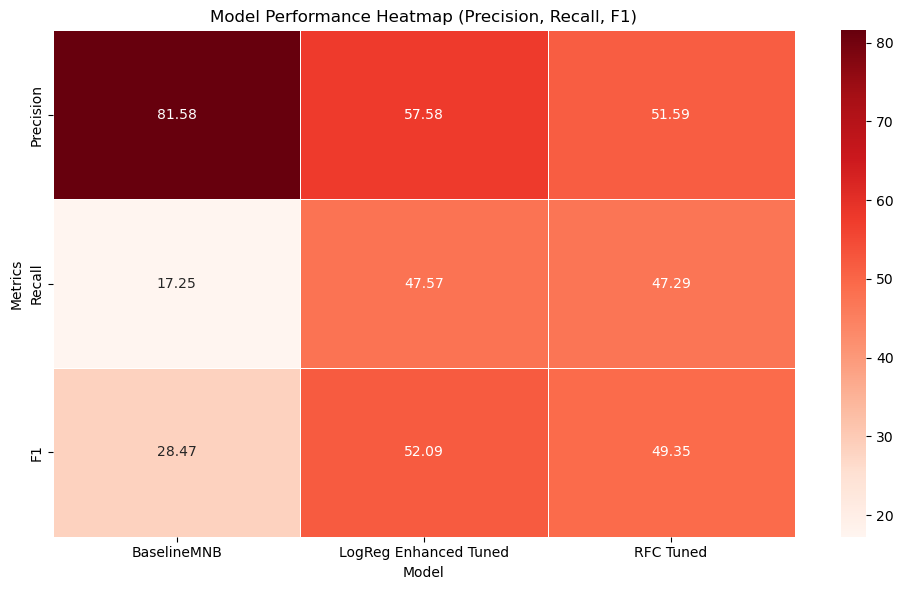

In [75]:
test_scores = test_df[['Precision', 'Recall', 'F1' ]]

plt.figure(figsize=(10, 6))
sns.heatmap(test_scores.T, annot=True, cmap='Reds', cbar=True, fmt='.2f', linewidths=0.5)
plt.title('Model Performance Heatmap (Precision, Recall, F1)')
plt.xlabel('Model')
plt.ylabel('Metrics')
plt.tight_layout()
plt.savefig("model_heatmap.png", dpi=300, bbox_inches='tight')

plt.show();



Let's look at it from a different angle: a grouped bar chart.

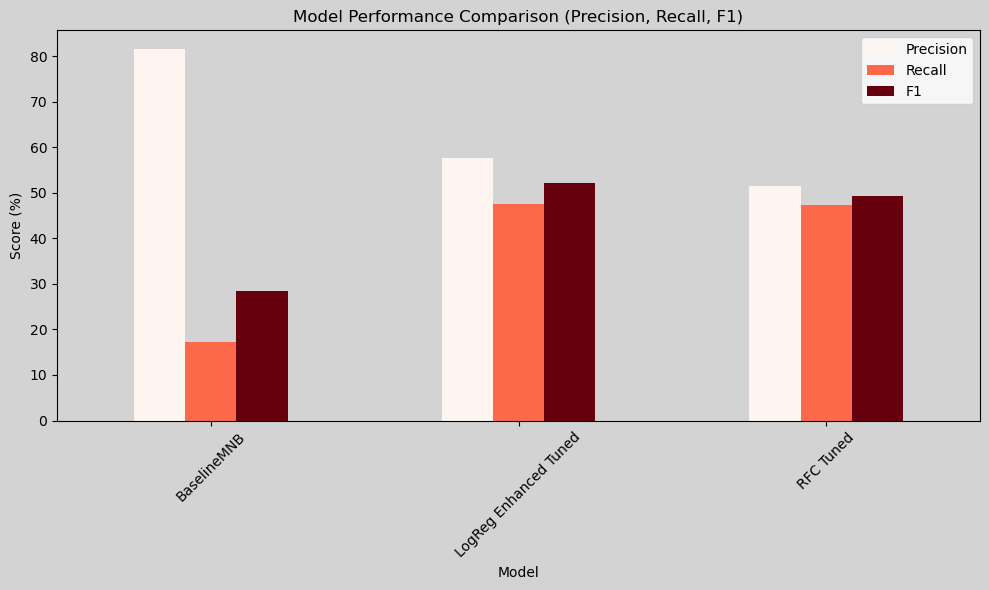

In [76]:
# Plot grouped bar chart
ax = test_df.plot(kind='bar', figsize=(10, 6), cmap='Reds', rot=45)

# Change the background color to gray
plt.gcf().set_facecolor('lightgray')
ax.set_facecolor('lightgray')

plt.title('Model Performance Comparison (Precision, Recall, F1)')
plt.xlabel('Model')
plt.ylabel('Score (%)')
plt.tight_layout()

plt.savefig("model_group_barchart.png", dpi=300, bbox_inches='tight')

plt.show();


Here's what this tells us:
1. The final RFC model is the most balanced model, with BaselineMNB the most unbalanced.
2. All of the models struggle to varying degrees with capturing all Positive cases, with many Positives falling through the cracks, indicating that despite our efforts to account for the class imbalance our models still failed to fully absorb Positive cases in their training.
3. All three models perform best at correctly keeping from misclassifying Not Positive as Positive, the issue lies in accidentally classifying Positives as Not Positives.

#### Feature Importances

While we have a better idea at how the models compare to each other, let's see what our findings can tell us about Feature Importances, or which words were calculated to have significance in determining whether a tweet was Positive or Not Positive.

Since RFC was by far our most balanced model, let's seek the Feature Importances from there. To do this, we will need to combine both TF-IDF scores as well as Fasttext information.

In [77]:
# getting feature importances from the classifier
importances = enhanced_rfc_pipe.named_steps['classifier'].feature_importances_

# getting the number of TF-IDF features and FastText embeddings
fasttext_feature_size = fasttext_model.vector_size  
num_tfidf_features = enhanced_rfc_pipe.named_steps['feature_engineering'].vectorizer_.get_feature_names_out().shape[0]
num_embeddings = X_train.shape[0]  

# getting TF-IDF feature names
tfidf_feature_names = enhanced_rfc_pipe.named_steps['feature_engineering'].vectorizer_.get_feature_names_out()

# getting FastText word feature names 
embedding_feature_names = []
for text in X_train:  
    tokens = text.split()  
    for token in tokens:
        if token in fasttext_model:  # checking if  token has an embedding in FastText
            embedding_feature_names.append(token)

# forcing alignment between features and importances 
total_features = len(tfidf_feature_names) + len(embedding_feature_names)
num_importances = len(importances)

# if the number of importances is less than the total number of features, pad with NaN
if num_importances < total_features:
    importances = np.concatenate([importances, np.full(total_features - num_importances, np.nan)])

# if the number of importances is more than the total number of features, truncate to match
elif num_importances > total_features:
    importances = importances[:total_features]

# creating the feature names list
feature_names = np.concatenate([tfidf_feature_names, embedding_feature_names])


features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# sorting the features by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)


print(features_df.head(10))


               Feature  Importance
2889              cool    0.002254
7789           mention    0.002117
7153              link    0.002037
2563            circle    0.001755
7986   mention mention    0.001613
1032               app    0.001425
5079             great    0.001360
1599           awesome    0.001020
13349       today link    0.000933
7412              love    0.000748


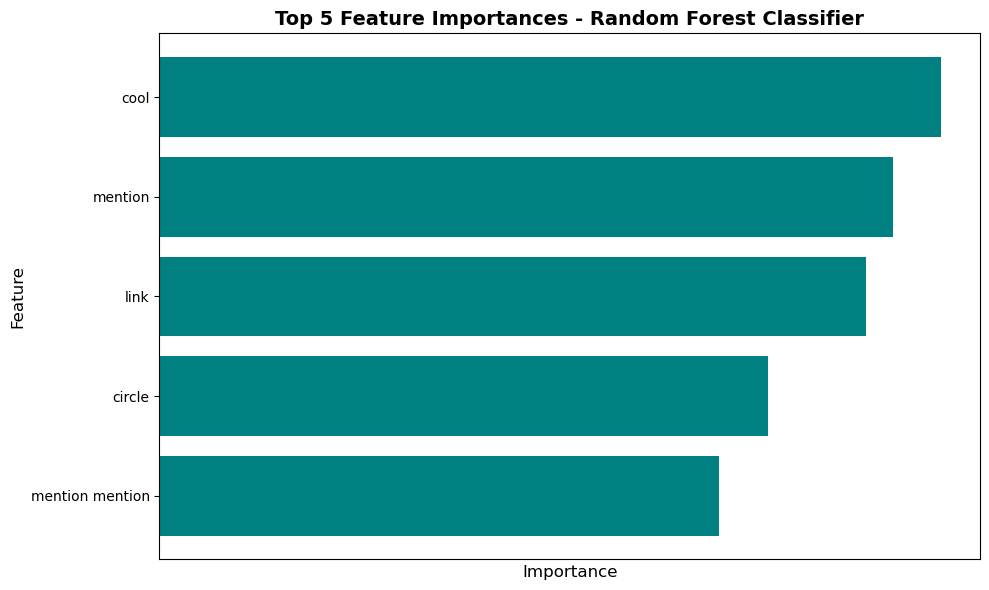

In [78]:
# plot the top 5 important features

top_features = features_df.head(5)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='teal')

plt.title('Top 5 Feature Importances - Random Forest Classifier', fontsize=14, weight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)

plt.xticks([]) # removing X-tick markers for clarity


plt.savefig("top_5_features.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

What this can lead us to conclude is that, despite the limitations and constraints we faced, we were able to successfully get our models to learn the relative significance of certain terms in the context of social media and Twitter.

# Conclusion

## Evaluation

Despite constraints that were out of our control, which we will elaborate on below, we were able to successfully run models of varying rates of efficacy that processed texts from tweets and social media and used the insight to classify tweets as Positive or Not Positive. As outlined above, our emphasis was on Precision, which is essentially a measure of how good our models were at keeping Not Positive sentiments out of the Positive category, which we achieved.

Overall, we built models that were adept at **correctly identifying Positive sentiments while keeping out Not Positive sentiments**. 

However, the weakness of our models comes in **allowing too many Positive sentiments to fall through the cracks** and be misclassified as Not Positive.

## Limitations

We faced three main limitations.

**The first concerns our dataset itself.** Though 9,000 tweets is a decent number, we would need more if we wanted to build a truly robust binary classification model, as the robustness of the model is correlated to the amount of data available to train on. Furthermore, despite our best attempts at reconciling the class imbalance, we faced very limited success, and the best remedy for this issue is a larger dataset with more Positive cases to train on. In relation to the dataset itself, seeing as it was from 2013 (12 years ago as of the time of this writing), having a more updated dataset with recent tweets would assist us, not only because of changes to Twitter regulations as far as character limits, but also in terms of evolutions in slang and language used regularly on the internet generally, which any model trained on such an old dataset would find difficulty in processing.

**Second, we faced severe limitations in terms of hardware**, which had a negative impact on our ability to run appropriate models. Ideally we would have been able to run heavier models, such as deep learning or neural networks, that would have been optimal for this endeavor were it not for the inability for these models to run on our current equipment. In particular, we would have benefited immensely from utilizing the **BERTweet (Bidirectional Encoder Representations from Transformers)**, a Deep Learning model which is well-suited for analyzing tweets in particular as it is trained on 850 million English tweets and can process special characters such as emojies, hashtags, etc., and is capable of determining contextual meaning from limited text as tweets had a limit of 140 characters back in 2013, which is when our dataset was compiled. 

**The third limitation is closely related to the second in terms of time constraints.** Not only would better hardware allow us to run better models that are more efficient and sophisticated, but with more time we could have fleshed out different types of models and been able to experiment more effectively with strategies aimed at operationalizing features, etc.

## Recommendations & Next Steps

In order to build on these findings, we have three main recommended next steps:
1. Gather an updated and more recent dataset that is 50-100% larger than our current dataset to allow for more effective model training that could be applied and updated for future use.
2. Ensure that the new dataset is more well-balanced so that we can train our models to more effectively classify Positive sentiments.
3. Invest in superior hardware so that we can make use of more efficient and more sophisticated models that are better-suited for the task of sentiment analysis and classification specifically for social media and Twitter, namely BERTweet or other deep learning models.